# Project Akhir Mata Kuliah Kecerdasan Artifisial
> DETEKSI DINI PNEUMONIA PADA CITRA X-RAY PARU MENGGUNAKAN HYBRID FEATURE EXTRACTION (HOG & LBP) DENGAN ANALISIS KOMPARATIF MODEL DECISION TREE, RANDOM FOREST, DAN XGBOOST

**Dosen Pengampu**
- Kartika Chandra Dewi, S.Si., M.Si.

**Anggota Kelompok**
- Muhammad Habib Nur Aiman (24031554152)
- Rabbani Yuki Arfiansyach (24031554131)
- M. Habiburrohman Al-Fathir (24031554145)
- Frendy Zahril Ramadhani (24031554187)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

# Library Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Exploratory Data Analysis**

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

base_dir = '/content/drive/MyDrive/KECERDASAN ARITIFISIAL/Datasets'

splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

dataset_stats = []

print("Mulai menghitung file...")
for split in splits:
    for label in classes:
        folder_path = os.path.join(base_dir, split, label)

        if os.path.exists(folder_path):
            num_images = len(os.listdir(folder_path))
            dataset_stats.append({'Split': split, 'Label': label, 'Jumlah': num_images})
            print(f"[{split.upper()}] - {label}: {num_images} gambar")
        else:
            print(f"Warning: Folder tidak ditemukan di {folder_path}")

df = pd.DataFrame(dataset_stats)

Mulai menghitung file...
[TRAIN] - NORMAL: 1341 gambar
[TRAIN] - PNEUMONIA: 3875 gambar
[VAL] - NORMAL: 8 gambar
[VAL] - PNEUMONIA: 8 gambar
[TEST] - NORMAL: 234 gambar
[TEST] - PNEUMONIA: 390 gambar


### **Visualisasi Distribusi Kelas (Class Balance)**

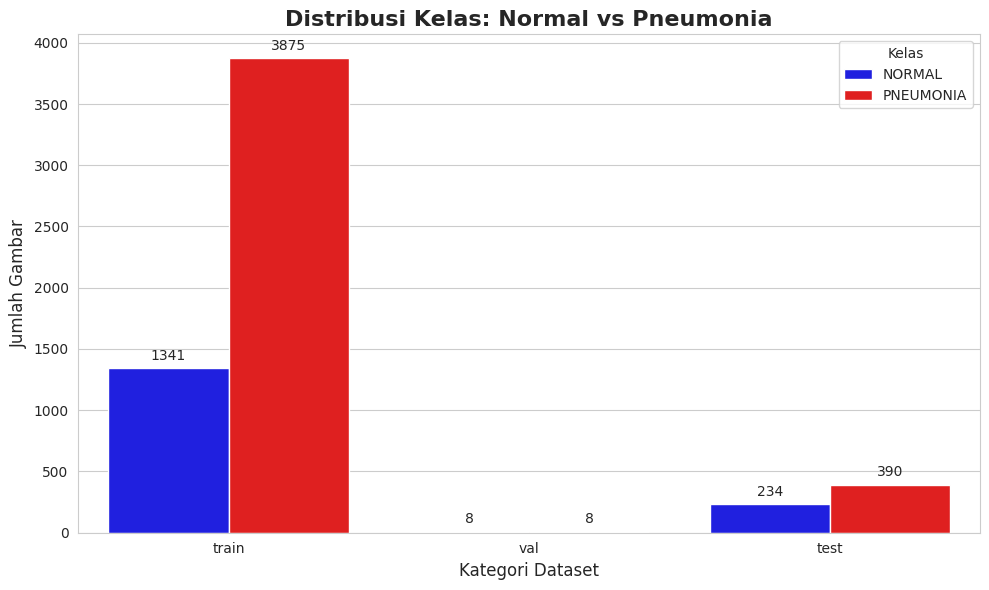

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(data=df, x='Split', y='Jumlah', hue='Label', palette=['blue', 'red'])

plt.title('Distribusi Kelas: Normal vs Pneumonia', fontsize=16, fontweight='bold')
plt.xlabel('Kategori Dataset', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.legend(title='Kelas')

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()

### **Analisis Distribusi Ukuran Gambar**

Sedang membaca dimensi gambar (ini mungkin memakan waktu bergantung koneksi Drive)...


TEST - PNEUMONIA: 100%|██████████| 390/390 [00:05<00:00, 75.44it/s] 


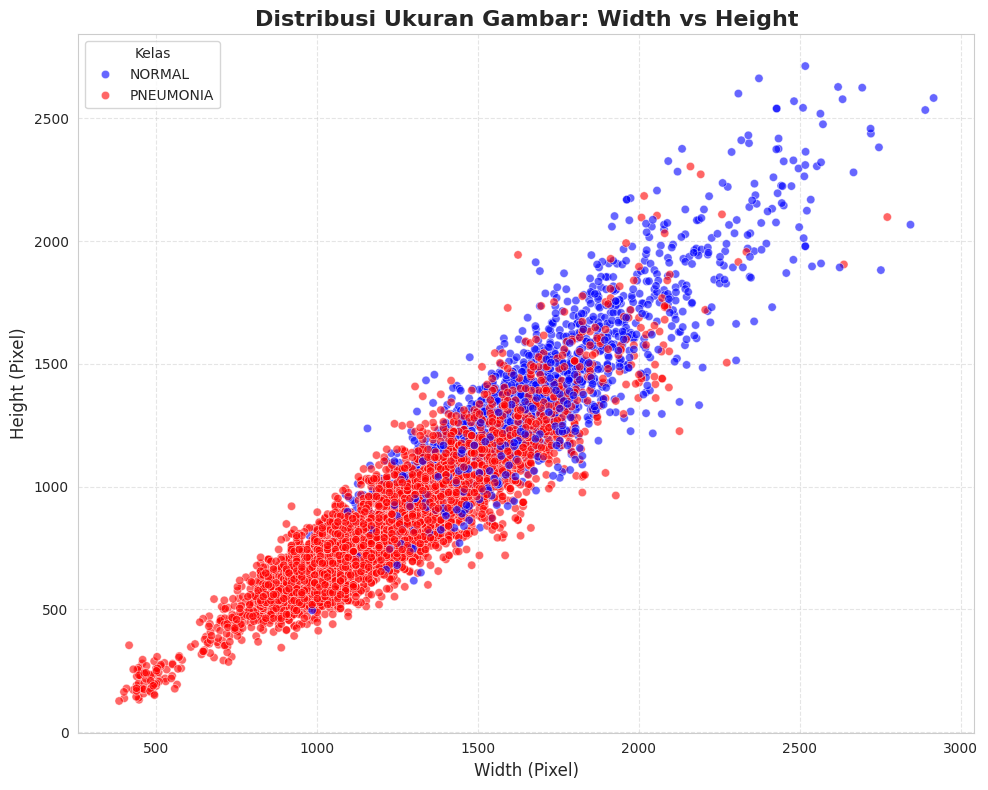


--- Statistik Ukuran Gambar ---
            Width                                                          \
            count         mean         std    min     25%     50%     75%   
Label                                                                       
NORMAL     1583.0  1686.379659  305.316210  912.0  1472.0  1654.0  1848.0   
PNEUMONIA  4273.0  1195.069272  285.145232  384.0  1000.0  1160.0  1360.0   

                   Height                                                  \
              max   count         mean         std    min     25%     50%   
Label                                                                       
NORMAL     2916.0  1583.0  1378.648768  343.017920  496.0  1140.0  1323.0   
PNEUMONIA  2772.0  4273.0   819.553943  270.861725  127.0   640.0   776.0   

                           
              75%     max  
Label                      
NORMAL     1554.0  2713.0  
PNEUMONIA   960.0  2304.0  


In [ ]:
from PIL import Image
from tqdm import tqdm

img_dims = []

print("Sedang membaca dimensi gambar (ini mungkin memakan waktu bergantung koneksi Drive)...")

for split in splits:
    for label in classes:
        folder_path = os.path.join(base_dir, split, label)

        if os.path.exists(folder_path):
            files = os.listdir(folder_path)

            for f in tqdm(files, desc=f"{split.upper()} - {label}"):
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    f_path = os.path.join(folder_path, f)
                    try:
                        with Image.open(f_path) as img:
                            w, h = img.size
                            img_dims.append({
                                'Split': split,
                                'Label': label,
                                'Width': w,
                                'Height': h
                            })
                    except Exception as e:
                        pass

df_dims = pd.DataFrame(img_dims)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_dims, x='Width', y='Height', hue='Label', alpha=0.6, palette=['blue', 'red'])

plt.title('Distribusi Ukuran Gambar: Width vs Height', fontsize=16, fontweight='bold')
plt.xlabel('Width (Pixel)', fontsize=12)
plt.ylabel('Height (Pixel)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Kelas')
plt.tight_layout()
plt.show()

print("\n--- Statistik Ukuran Gambar ---")
print(df_dims.groupby('Label')[['Width', 'Height']].describe())

### **Visualisasi Sampel Acak**

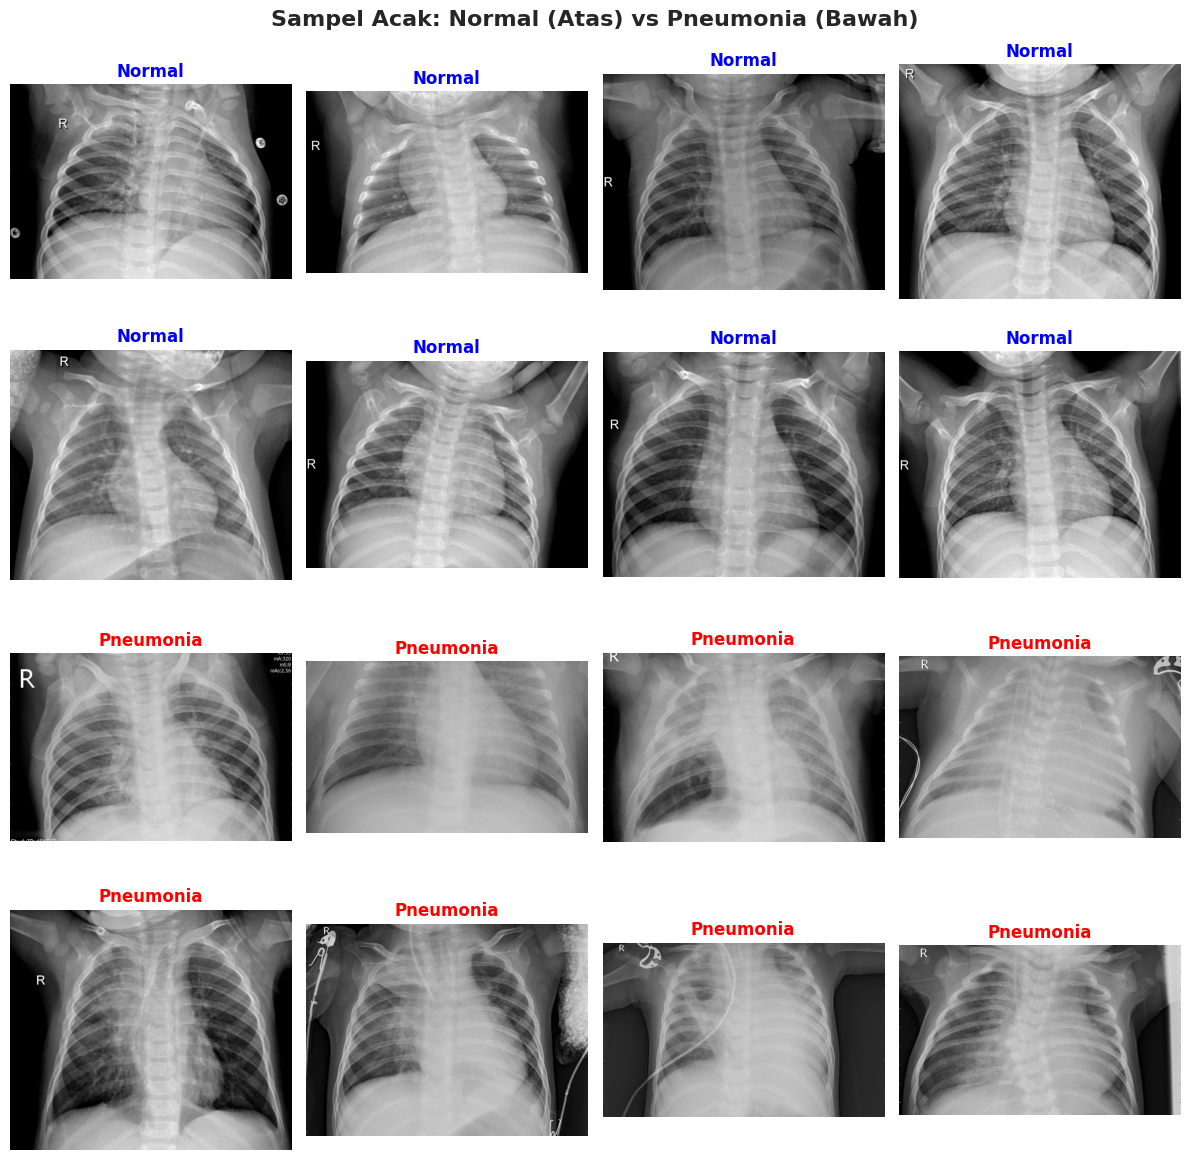

In [ ]:
import random
import matplotlib.image as mpimg

base_dir = '/content/drive/MyDrive/KECERDASAN ARITIFISIAL/Datasets/train' # Kita ambil sampel dari data TRAIN saja
classes = ['NORMAL', 'PNEUMONIA']

def get_random_images(label, count=8):
    folder_path = os.path.join(base_dir, label)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random_files = random.sample(files, count)
    return [os.path.join(folder_path, f) for f in random_files]

normal_imgs = get_random_images('NORMAL', 8)
pneumonia_imgs = get_random_images('PNEUMONIA', 8)

all_imgs = normal_imgs + pneumonia_imgs
labels = ['Normal'] * 8 + ['Pneumonia'] * 8

plt.figure(figsize=(12, 12))
plt.suptitle('Sampel Acak: Normal (Atas) vs Pneumonia (Bawah)', fontsize=16, fontweight='bold')

for i, img_path in enumerate(all_imgs):
    plt.subplot(4, 4, i + 1)

    try:
        img = mpimg.imread(img_path)
        plt.imshow(img, cmap='gray')
        color = 'blue' if labels[i] == 'Normal' else 'red'
        plt.title(labels[i], color=color, fontweight='bold')

        plt.axis('off')
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.show()

### **Analisis Distribusi Intensitas Pixel**

Mengambil data pixel dari kelas NORMAL...


100%|██████████| 500/500 [00:21<00:00, 23.09it/s]


Mengambil data pixel dari kelas PNEUMONIA...


100%|██████████| 500/500 [00:05<00:00, 99.69it/s]


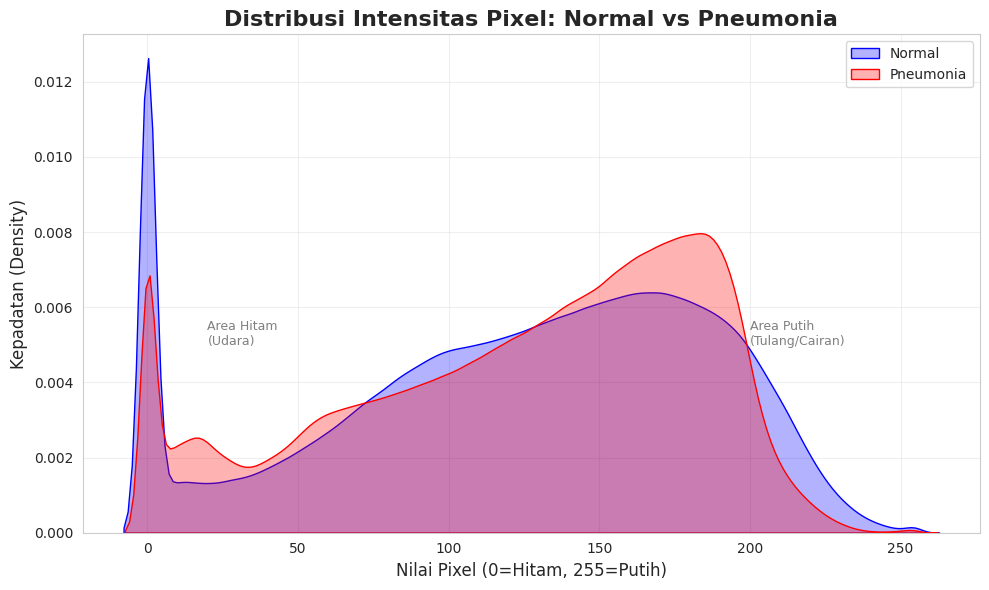


--- Analisis ---
Rata-rata Nilai Pixel Normal: 122.97
Rata-rata Nilai Pixel Pneumonia: 124.06


In [ ]:
import cv2

base_dir = '/content/drive/MyDrive/KECERDASAN ARITIFISIAL/Datasets/train'

SAMPLE_SIZE = 500
IMG_SIZE = 128

def get_pixel_values(label):
    folder_path = os.path.join(base_dir, label)
    files = os.listdir(folder_path)

    if len(files) > SAMPLE_SIZE:
        files = np.random.choice(files, SAMPLE_SIZE, replace=False)

    pixel_values = []

    print(f"Mengambil data pixel dari kelas {label}...")
    for f in tqdm(files):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(folder_path, f)
            try:
                img = cv2.imread(path, 0)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                pixel_values.extend(img.flatten())
            except Exception as e:
                pass

    return pixel_values

normal_pixels = get_pixel_values('NORMAL')
pneumonia_pixels = get_pixel_values('PNEUMONIA')

plt.figure(figsize=(10, 6))
sns.kdeplot(normal_pixels, color='blue', label='Normal', fill=True, alpha=0.3)
sns.kdeplot(pneumonia_pixels, color='red', label='Pneumonia', fill=True, alpha=0.3)

plt.title('Distribusi Intensitas Pixel: Normal vs Pneumonia', fontsize=16, fontweight='bold')
plt.xlabel('Nilai Pixel (0=Hitam, 255=Putih)', fontsize=12)
plt.ylabel('Kepadatan (Density)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.text(200, 0.005, 'Area Putih\n(Tulang/Cairan)', fontsize=9, color='gray')
plt.text(20, 0.005, 'Area Hitam\n(Udara)', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

print("\n--- Analisis ---")
print(f"Rata-rata Nilai Pixel Normal: {np.mean(normal_pixels):.2f}")
print(f"Rata-rata Nilai Pixel Pneumonia: {np.mean(pneumonia_pixels):.2f}")

### **Mean Image (Citra Rata-rata)**

Menghitung rata-rata gambar untuk NORMAL...


100%|██████████| 1341/1341 [01:00<00:00, 22.32it/s]


Menghitung rata-rata gambar untuk PNEUMONIA...


100%|██████████| 3875/3875 [00:27<00:00, 139.87it/s]


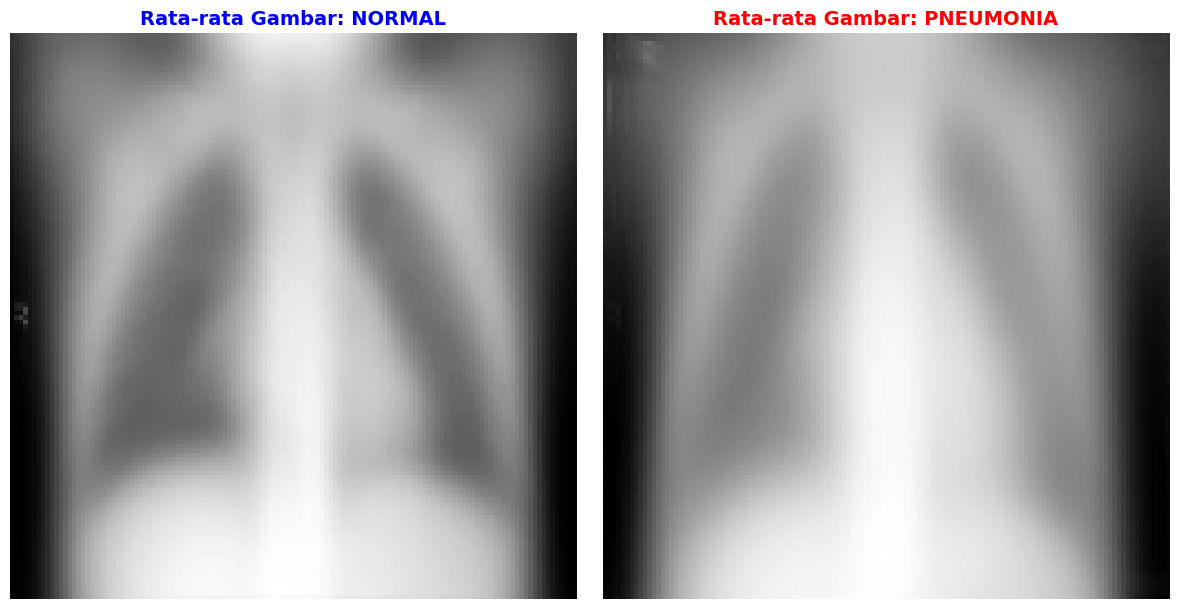

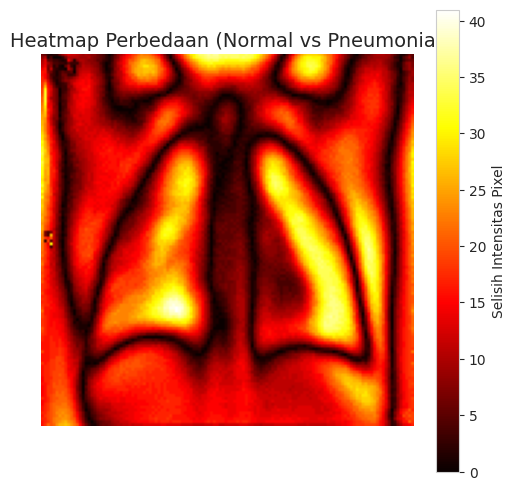

In [ ]:
base_dir = '/content/drive/MyDrive/KECERDASAN ARITIFISIAL/Datasets/train'
IMG_SIZE = 128

def compute_mean_image(label):
    folder_path = os.path.join(base_dir, label)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    mean_img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    count = 0

    print(f"Menghitung rata-rata gambar untuk {label}...")
    for f in tqdm(files):
        try:
            path = os.path.join(folder_path, f)
            img = cv2.imread(path, 0)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            mean_img += img
            count += 1
        except:
            pass

    mean_img /= count

    mean_img = np.array(mean_img, dtype=np.uint8)
    return mean_img

mean_normal = compute_mean_image('NORMAL')
mean_pneumonia = compute_mean_image('PNEUMONIA')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(mean_normal, cmap='gray')
plt.title('Rata-rata Gambar: NORMAL', fontsize=14, fontweight='bold', color='blue')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mean_pneumonia, cmap='gray')
plt.title('Rata-rata Gambar: PNEUMONIA', fontsize=14, fontweight='bold', color='red')
plt.axis('off')

plt.tight_layout()
plt.show()

# Ini untuk melihat area mana yang paling beda
diff = cv2.absdiff(mean_normal, mean_pneumonia)
plt.figure(figsize=(6, 6))
plt.imshow(diff, cmap='hot')
plt.title('Heatmap Perbedaan (Normal vs Pneumonia)', fontsize=14)
plt.colorbar(label='Selisih Intensitas Pixel')
plt.axis('off')
plt.show()

# **BUILD MODEL**

### **FEATURE ENGINEERING**

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm #progress

BASE_DIR = "/content/drive/MyDrive/KECERDASAN ARITIFISIAL/Datasets"
IMG_SIZE = 256

LBP_RADIUS = 3
LBP_POINTS = 8 * LBP_RADIUS

def extract_features(image_path):
  img  = cv2.imread(image_path, 0)

  if img is None:
    return None

  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

  # ClipLimit=2.0 (kontras), TileGridSize=(8,8) (ukuran blok lokal)
  # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  # img = clahe.apply(img)

  # HOG (Histrogram Of Oriented Gradient) -> bentuk
  hog_feats = hog(img, orientations = 9, pixels_per_cell = (8,8),
                  cells_per_block  = (2, 2), block_norm = 'L2-Hys', transform_sqrt = True)

  # LBP (Local Binary Pattern) -> Tekstur
  lbp_image = local_binary_pattern(img, LBP_POINTS, LBP_RADIUS, method = 'uniform')

  n_bins = int(lbp_image.max() + 1)
  lbp_hist, _ = np.histogram(lbp_image.ravel(), bins = n_bins, range = (0, n_bins), density = True)

  # 2. Fitur BARU (Global Intensity)
  mean_val = np.mean(img)
  std_val = np.std(img)
  global_feats = np.array([mean_val, std_val])

  combined_features = np.hstack([hog_feats, lbp_hist, global_feats])

  return combined_features

def load_data(split_name):
  folder_path = os.path.join(BASE_DIR, split_name)
  categories = ['NORMAL', 'PNEUMONIA']

  features = []
  labels = []

  print(f"PROSES DATA: {split_name.upper()}...")

  for label_name in categories:

    class_num = 0 if label_name == 'NORMAL' else 1
    path = os.path.join(folder_path, label_name)
    files = os.listdir(path)
    for img_name in tqdm(files, desc = f"{label_name}"):
      try:
        full_path = os.path.join(path, img_name)

        data_vector = extract_features(full_path)

        if data_vector is not None:
          features.append(data_vector)
          labels.append(class_num)
      except Exception as e:
        pass

  return np.array(features), np.array(labels)

print("EKSTRASI FITUR DIMULAI")

X_test, y_test = load_data('test')
print(f"SELESAI!, Dimensi X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train, y_train = load_data('train')
print(f"SELESAI!, Dimensi X_train: {X_train.shape}, y_train: {y_train.shape}")

X_val, y_val = load_data('val')
print(f"SELESAI!, Dimensi X_val: {X_val.shape}, y_val: {y_val.shape}")

EKSTRASI FITUR DIMULAI
PROSES DATA: TEST...


PNEUMONIA: 100%|██████████| 390/390 [00:29<00:00, 13.39it/s]


SELESAI!, Dimensi X_test: (624, 34624), y_test: (624,)
PROSES DATA: TRAIN...


PNEUMONIA: 100%|██████████| 3875/3875 [05:05<00:00, 12.69it/s]


SELESAI!, Dimensi X_train: (5216, 34624), y_train: (5216,)
PROSES DATA: VAL...


PNEUMONIA: 100%|██████████| 8/8 [00:00<00:00, 10.75it/s]

SELESAI!, Dimensi X_val: (16, 34624), y_val: (16,)


In [ ]:
print("Normalisasi data dengan MinMaxScaler...")
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

print("MinMaxScaler selesai!")
print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_test: {X_test.shape}")
print(f"Bentuk X_val: {X_val.shape}")

Normalisasi data dengan MinMaxScaler...
MinMaxScaler selesai!
Bentuk X_train: (5216, 34624)
Bentuk X_test: (624, 34624)
Bentuk X_val: (16, 34624)


## **PCA**

In [ ]:
from sklearn.decomposition import PCA

# n_components=0.95 artinya: "Carikan jumlah fitur minimal yang bisa menyimpan 95% informasi"
pca = PCA(n_components=0.95, random_state=42)

# Fit pada data TRAIN saja
X_train_pca = pca.fit_transform(X_train) # X_train_scaled dari tahap sebelumnya
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

print(f"Dimensi Asli: {X_train.shape[1]}")
print(f"Dimensi Setelah PCA: {X_train_pca.shape[1]}")

Dimensi Asli: 34624
Dimensi Setelah PCA: 3380


### **CARI FITUR TERPENTING**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# 1. Latih Random Forest HANYA untuk milih fitur (bukan prediksi)
print("Sedang menyeleksi fitur penting...")
selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector.fit(X_train_pca, y_train)

# 2. Ambil fitur yang penting saja
model_selector = SelectFromModel(selector, prefit=True)
X_train_selected = model_selector.transform(X_train_pca)
X_test_selected = model_selector.transform(X_test_pca)

print(f"Fitur awal: {X_train_pca.shape[1]}")
print(f"Fitur terpilih: {X_train_selected.shape[1]}")

Sedang menyeleksi fitur penting...
Fitur awal: 3380
Fitur terpilih: 1038


### **HANDLING IMBALANCE : SMOTE**

In [ ]:
print("DATA SEBELUM DI SMOTE")
unique, counts = np.unique(y_train, return_counts=True)
print(f"Jumlah Data Asli: {dict(zip(unique, counts))}")

print("Menyeimbangkan data dengan SMOTE")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

print("DATA SETELAH DI SMOTE")
unique_res, counts_res = np.unique(y_train_resampled, return_counts = True)
print(f"Jumlah Data Seimbang : {dict(zip(unique_res, counts_res))}")
print("SMOTE SELESAI")


DATA SEBELUM DI SMOTE
Jumlah Data Asli: {np.int64(0): np.int64(1341), np.int64(1): np.int64(3875)}
Menyeimbangkan data dengan SMOTE
DATA SETELAH DI SMOTE
Jumlah Data Seimbang : {np.int64(0): np.int64(3875), np.int64(1): np.int64(3875)}
SMOTE SELESAI


In [ ]:
print("Normalisasi Global Selesai!")
print(f"Contoh data sebelum: {X_train[0][:5]}") # Lihat 5 angka awal
print(f"Contoh data sesudah: {X_train_resampled[0][:5]}") # Angkanya akan berubah lebih rapi

Normalisasi Global Selesai!
Contoh data sebelum: [0.42337899 0.         0.         0.         0.        ]
Contoh data sesudah: [10.58466481 -7.41204804 -0.69300455 -1.09210081 -3.05871788]


## **TRAINING MODEL**

In [ ]:
if 'final_results' not in locals():
    final_results = []

### **DECISION TREE**

TRAINING MODEL: DECISION TREE

 =========== HASIL DECISION TREE ============
Akurasi: 0.7275641025641025
Recall: 0.9179487179487179

Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.41      0.53       234
           1       0.72      0.92      0.81       390

    accuracy                           0.73       624
   macro avg       0.74      0.66      0.67       624
weighted avg       0.73      0.73      0.70       624



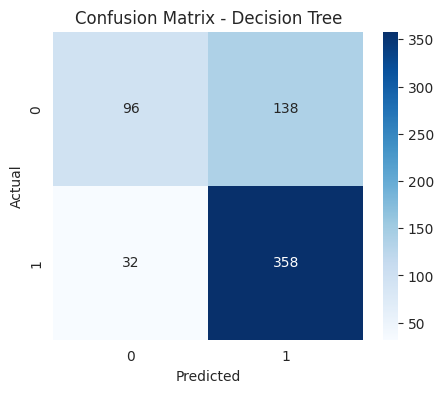

In [ ]:
print("TRAINING MODEL: DECISION TREE")
dt_model = DecisionTreeClassifier(random_state = 42)
dt_model.fit(X_train_resampled, y_train_resampled)

y_pred_dt = dt_model.predict(X_test_selected)

acc_dt = accuracy_score(y_test, y_pred_dt)
rec_dt = recall_score(y_test, y_pred_dt, pos_label = 1)

print(f"\n =========== HASIL DECISION TREE ============")
print(f"Akurasi: {acc_dt}")
print(f"Recall: {rec_dt}")
print(f"\nClassification Report: ")
print(classification_report(y_test, y_pred_dt))

final_results.append({
    "Model": "Decision Tree", "Akurasi": acc_dt, "Recall": rec_dt
})

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **RANDOM FOREST**

TRAINING MODEL: RANDOM FOREST

 HASIL RANDOM FOREST
Akurasi : 0.7291666666666666
Recall (Sensitivitas) : 0.9615384615384616

 Classification Report
              precision    recall  f1-score   support

           0       0.84      0.34      0.49       234
           1       0.71      0.96      0.82       390

    accuracy                           0.73       624
   macro avg       0.78      0.65      0.65       624
weighted avg       0.76      0.73      0.69       624



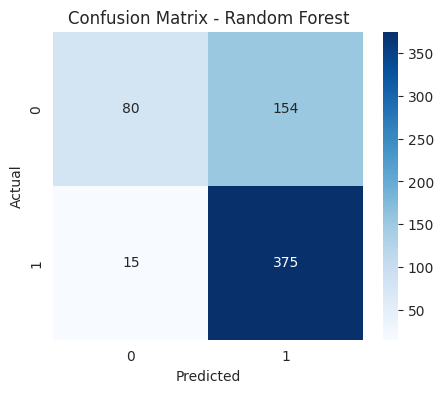

In [ ]:
print("TRAINING MODEL: RANDOM FOREST")
rf_model = RandomForestClassifier(random_state=42, n_estimators=150, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_selected)

acc_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1)

print(f"\n HASIL RANDOM FOREST")
print(f"Akurasi : {acc_rf}")
print(f"Recall (Sensitivitas) : {recall_rf}")
print("\n Classification Report")
classification_report(y_test, y_pred_rf, target_names = ['Normal', 'Pneumonia'])

final_results.append({
    "Model": "Random Forest", "Akurasi" : acc_rf, "Recall" : recall_rf
})

print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **XGBOOST**

TRAINING MODEL : XGBOOST


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:44:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 HASIL XGBOOST
Akurasi : 0.7483974358974359
Recall (Sensitivitas) : 0.9743589743589743

 Classification Report
              precision    recall  f1-score   support

           0       0.90      0.37      0.53       234
           1       0.72      0.97      0.83       390

    accuracy                           0.75       624
   macro avg       0.81      0.67      0.68       624
weighted avg       0.79      0.75      0.72       624



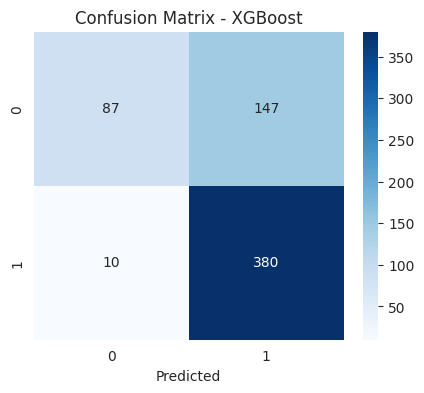

--- Threshold 0.7 ---
Akurasi: 0.7692307692307693
Recall: 0.9641025641025641


In [ ]:
print("TRAINING MODEL : XGBOOST")

xgb_model = XGBClassifier(random_state = 42, n_jobs = -1, use_label_encoder = False, eval_metric = 'logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test_selected)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb, pos_label = 1)

# 1. Ambil probabilitas (keyakinan) model
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1] # Ambil kolom 1 (Pneumonia)

# 2. Set Threshold Baru (Misal 0.7 atau 70%)
threshold = 0.7
y_pred_tuned = (y_pred_proba > threshold).astype(int)

print(f"\n HASIL XGBOOST")
print(f"Akurasi : {acc_xgb}")
print(f"Recall (Sensitivitas) : {recall_xgb}")
print("\n Classification Report")
classification_report(y_test, y_pred_xgb, target_names = ['Normal', 'Pneumonia'])

final_results.append({
    "Model" : "XGBoost", "Akurasi" : acc_xgb, "Recall" : recall_xgb
})

print(classification_report(y_test, y_pred_xgb))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.show()

# 3. Cek Hasilnya
print(f"--- Threshold {threshold} ---")
print(f"Akurasi: {accuracy_score(y_test, y_pred_tuned)}")
print(f"Recall: {recall_score(y_test, y_pred_tuned)}")

In [ ]:
final_results

[{'Model': 'Decision Tree',
  'Akurasi': 0.7275641025641025,
  'Recall': 0.9179487179487179},
 {'Model': 'Random Forest',
  'Akurasi': 0.7291666666666666,
  'Recall': 0.9615384615384616},
 {'Model': 'XGBoost',
  'Akurasi': 0.7483974358974359,
  'Recall': 0.9743589743589743}]


TABEL SKOR AKHIR
           Model   Akurasi    Recall
0  Decision Tree  0.727564  0.917949
1  Random Forest  0.729167  0.961538
2        XGBoost  0.748397  0.974359


/tmp/ipython-input-78581401.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=df_res, x="Model", y="Akurasi", palette="viridis")
/tmp/ipython-input-78581401.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=df_res, x="Model", y="Recall", palette="magma")


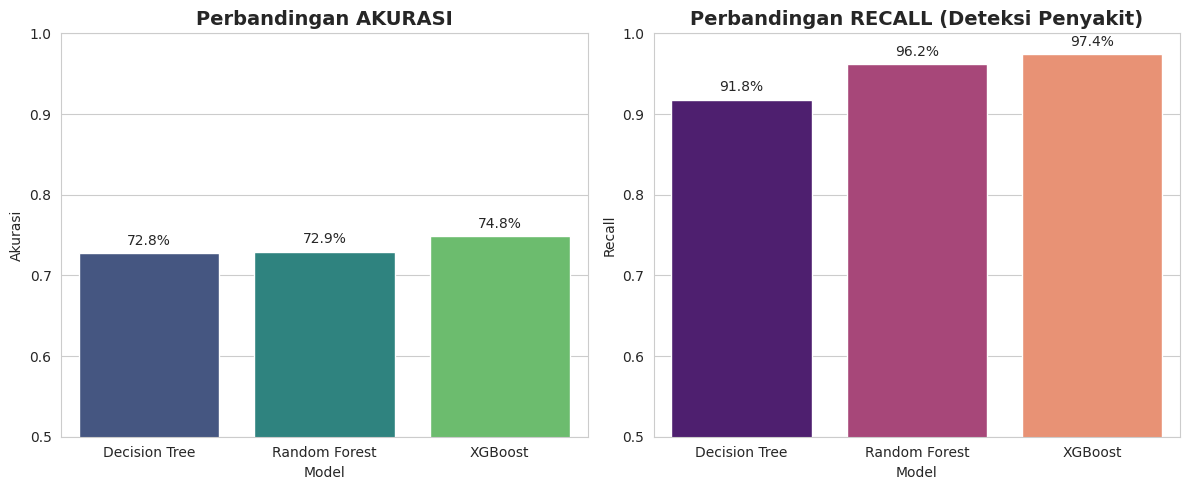


 KESIMPULAN:
1. Model dengan Akurasi Tertinggi: XGBoost (74.84%)
2. Model paling jago deteksi orang sakit (Recall Tertinggi): XGBoost (97.44%)


In [ ]:
# Buat DataFrame dari hasil yang sudah dikumpulkan
df_res = pd.DataFrame(final_results)

# Hapus duplikat jika cell dijalankan berulang kali
df_res = df_res.drop_duplicates(subset=['Model'], keep='last')

print("\nTABEL SKOR AKHIR")
print(df_res)

# Visualisasi Grafik Batang
plt.figure(figsize=(12, 5))

# Plot 1: Akurasi
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=df_res, x="Model", y="Akurasi", palette="viridis")
plt.title("Perbandingan AKURASI", fontsize=14, fontweight='bold')
plt.ylim(0.5, 1.0)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

# Plot 2: Recall
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=df_res, x="Model", y="Recall", palette="magma")
plt.title("Perbandingan RECALL (Deteksi Penyakit)", fontsize=14, fontweight='bold')
plt.ylim(0.5, 1.0)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Kesimpulan Otomatis
best_acc = df_res.loc[df_res['Akurasi'].idxmax()]
best_rec = df_res.loc[df_res['Recall'].idxmax()]

print(f"\n KESIMPULAN:")
print(f"1. Model dengan Akurasi Tertinggi: {best_acc['Model']} ({best_acc['Akurasi']*100:.2f}%)")
print(f"2. Model paling jago deteksi orang sakit (Recall Tertinggi): {best_rec['Model']} ({best_rec['Recall']*100:.2f}%)")

In [ ]:
# import joblib

# # Save the Decision Tree model
# joblib.dump(dt_model, 'decision_tree_model.pkl')
# print("Decision Tree model saved as decision_tree_model.pkl")

# # Save the Random Forest model
# joblib.dump(best_rf, 'random_forest_model.pkl')
# print("Random Forest model saved as random_forest_model.pkl")

# # Save the XGBoost model
# joblib.dump(best_xgb, 'xgboost_model.pkl')
# print("XGBoost model saved as xgboost_model.pkl")

# **VALIDASI MODEL TERBAIK**

In [ ]:
print("TAHAP VALIDASI AKHIR (SANITY CHECK)....")

model_final = xgb_model # Use xgb_model as best_xgb is not defined

# Apply PCA to X_val
X_val_pca = pca.transform(X_val)

# Apply feature selection to X_val_pca
X_val_selected = model_selector.transform(X_val_pca) # Corrected line

print(f"\n Memprediksi {len(X_val)}")
y_val_pred = model_final.predict(X_val_selected)

results_val = pd.DataFrame({
    'Label Asli': y_val,
    'Prediksi Model': y_val_pred
})

label_map = {0: 'Normal', 1: 'Pneumonia'}
results_val['Label Asli'] = results_val['Label Asli'].map(label_map)
results_val['Prediksi Model'] = results_val['Prediksi Model'].map(label_map)

results_val['Status'] = results_val['Label Asli'] == results_val['Prediksi Model']

print(f"\n HASIL PREDIKSI DATA VAL")
print(results_val)

correct = results_val[results_val['Status'] == True].shape[0]
total = results_val.shape[0]
print(f"\n Skor Akhir : {correct} / {total} Gambar Terprediksi Benar")

if correct == total:
  print("MODEL SEMPURNA SEMUA PREDIKSI DATA VALIDASI BENAR!")
elif correct > total*0.8:
  print("BAGUS MODEL HAMPIR BISA MEMPREDIKSI SEMUA DATA")
else:
  print("MODEL CUKUP BAGUS :)")

TAHAP VALIDASI AKHIR (SANITY CHECK)....

 Memprediksi 16

 HASIL PREDIKSI DATA VAL
   Label Asli Prediksi Model  Status
0      Normal         Normal    True
1      Normal         Normal    True
2      Normal         Normal    True
3      Normal      Pneumonia   False
4      Normal         Normal    True
5      Normal         Normal    True
6      Normal         Normal    True
7      Normal         Normal    True
8   Pneumonia      Pneumonia    True
9   Pneumonia      Pneumonia    True
10  Pneumonia      Pneumonia    True
11  Pneumonia      Pneumonia    True
12  Pneumonia      Pneumonia    True
13  Pneumonia      Pneumonia    True
14  Pneumonia      Pneumonia    True
15  Pneumonia      Pneumonia    True

 Skor Akhir : 15 / 16 Gambar Terprediksi Benar
BAGUS MODEL HAMPIR BISA MEMPREDIKSI SEMUA DATA


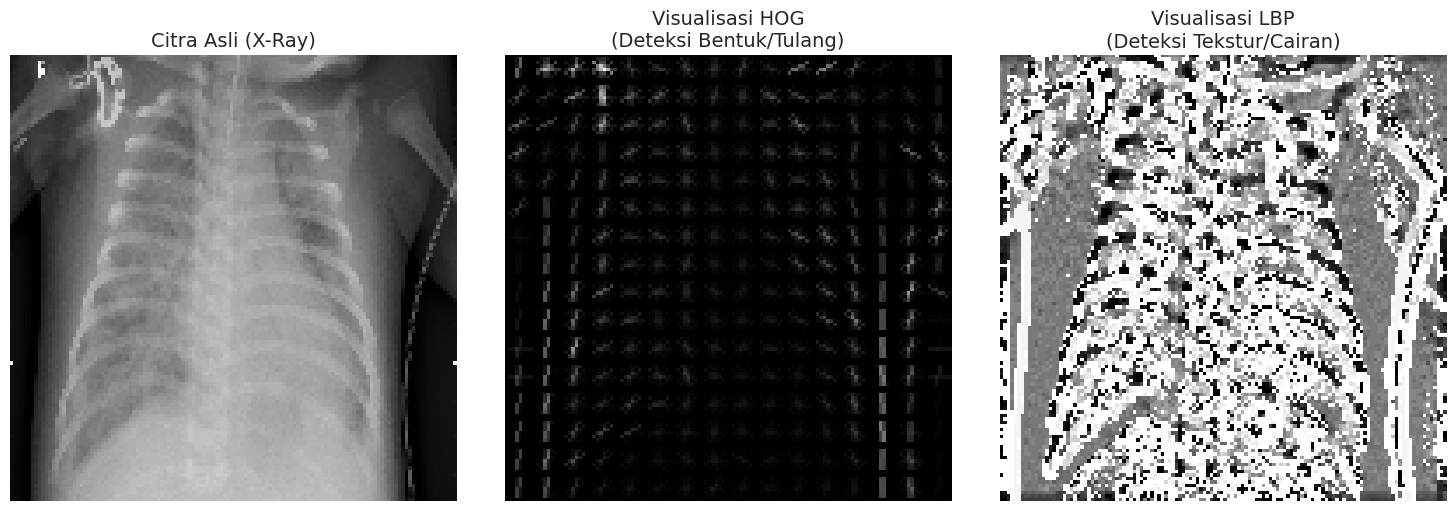

In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
import numpy as np

# Ganti dengan path salah satu gambar Pneumonia yang jelas
img_path = '/content/drive/MyDrive/KECERDASAN ARITIFISIAL/Datasets/train/PNEUMONIA/person1000_bacteria_2931.jpeg'
# Atau pilih sembarang file yang ada

# 1. Load & Preprocess
img = cv2.imread(img_path, 0)
img = cv2.resize(img, (128, 128))

# 2. HOG Visualization
# visualize=True akan mengembalikan gambar visualisasi HOG
_, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

# 3. LBP Visualization
radius = 3
n_points = 8 * radius
lbp_image = local_binary_pattern(img, n_points, radius, method='uniform')

# 4. Tampilkan Side-by-Side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Gambar Asli
ax1.imshow(img, cmap='gray')
ax1.set_title('Citra Asli (X-Ray)', fontsize=14)
ax1.axis('off')

# HOG (Bentuk)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Visualisasi HOG\n(Deteksi Bentuk/Tulang)', fontsize=14)
ax2.axis('off')

# LBP (Tekstur)
ax3.imshow(lbp_image, cmap='gray')
ax3.set_title('Visualisasi LBP\n(Deteksi Tekstur/Cairan)', fontsize=14)
ax3.axis('off')

plt.tight_layout()
plt.show()